In [0]:
import os
import numpy as np
import pandas as pd

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.window import Window

import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 18,4

![retail_erd](files/tables/cloudera_retail_db.png)

In [0]:
#Creating the Spark Session:

In [0]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("retail-database-analysis-python")
         .getOrCreate())

In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Out[71]: <pyspark.sql.context.SQLContext at 0x7f963513a3d0>

In [0]:
# Load the Data From Files Into DataFrames:

In [0]:
CUSTOMERS_DATA =   'dbfs:/FileStore/tables/customers.csv'
DEPARTMENTS_DATA = 'dbfs:/FileStore/tables/departments.csv'
CATEGORIES_DATA =  'dbfs:/FileStore/tables/categories.csv'
PRODUCTS_DATA =    'dbfs:/FileStore/tables/products.csv'
ORDERS_DATA =      'dbfs:/FileStore/tables/orders.csv'
ORDER_ITEMS_DATA = 'dbfs:/FileStore/tables/order_items.csv'

In [0]:
# above define path where we uplaod excel file as a TABLE
# Struc is USED for Schema

In [0]:
# define the schema, corresponding to a line in the csv data file for Customer
customers_schema = StructType([
    StructField('customer_id',       IntegerType(), nullable=True),
    StructField('customer_fname',    StringType(), nullable=True),
    StructField('customer_lname',    StringType(), nullable=True),
    StructField('customer_email',    StringType(), nullable=True),
    StructField('customer_password', StringType(), nullable=True),
    StructField('customer_street',   StringType(), nullable=True),
    StructField('customer_city',     StringType(), nullable=True),
    StructField('customer_state',    StringType(), nullable=True),
    StructField('customer_zipcode',  StringType(), nullable=True)])

In [0]:
departments_schema = StructType([
    StructField('department_id',   IntegerType(), nullable=True),
    StructField('department_name', StringType(), nullable=True)])

In [0]:
categories_schema = StructType([
    StructField('category_id',            IntegerType(), nullable=True),
    StructField('category_department_id', IntegerType(), nullable=True),
    StructField('category_name',          StringType(), nullable=True)])

In [0]:
products_schema = StructType([
    StructField('product_id',          IntegerType(), nullable=True),
    StructField('product_category_id', IntegerType(), nullable=True),
    StructField('product_name',        StringType(), nullable=True),
    StructField('product_description', StringType(), nullable=True),
    StructField('product_price',       FloatType(), nullable=True),
    StructField('product_image',       StringType(), nullable=True)])

In [0]:
orders_schema = StructType([
    StructField('order_id',          IntegerType(), nullable=True),
    StructField('order_date',        StringType(), nullable=True),
    StructField('order_customer_id', IntegerType(), nullable=True),
    StructField('order_status',      StringType(), nullable=True)])

In [0]:
order_items_schema = StructType([
    StructField('order_item_id',            IntegerType(), nullable=True),
    StructField('order_item_order_id',      IntegerType(), nullable=True),
    StructField('order_item_product_id',    IntegerType(), nullable=True),
    StructField('order_item_quantity',      IntegerType(), nullable=True),
    StructField('order_item_subtotal',      FloatType(), nullable=True),
    StructField('order_item_product_price', FloatType(), nullable=True)])

In [0]:
customers_df = spark.read.csv(path=CUSTOMERS_DATA, schema=customers_schema)
customers_df.cache()

departments_df = spark.read.csv(path=DEPARTMENTS_DATA, schema=departments_schema)
departments_df.cache()

categories_df = spark.read.csv(path=CATEGORIES_DATA, schema=categories_schema)
categories_df.cache()

products_df = spark.read.csv(path=PRODUCTS_DATA, schema=products_schema)
products_df.cache()

orders_df = spark.read.csv(path=ORDERS_DATA, schema=orders_schema)
orders_df.cache()

order_items_df = spark.read.csv(path=ORDER_ITEMS_DATA, schema=order_items_schema)
order_items_df.cache()

Out[81]: DataFrame[order_item_id: int, order_item_order_id: int, order_item_product_id: int, order_item_quantity: int, order_item_subtotal: float, order_item_product_price: float]

In [0]:
# Register all the DataFrames as Temporary Views
# for Sql quering we shift over main uploaded table into cache memory 

In [0]:
customers_df.createOrReplaceTempView("customers")
customers_df.select([col(choice) for choice in np.random.choice(customers_df.columns, size=5, replace=False)]).show(10)
#

+-------------+--------------+--------------------+--------------+--------------+
|customer_city|customer_lname|     customer_street|customer_fname|customer_state|
+-------------+--------------+--------------------+--------------+--------------+
|  Brownsville|     Hernandez|  6303 Heather Plaza|       Richard|            TX|
|    Littleton|       Barrett|9526 Noble Embers...|          Mary|            CO|
|       Caguas|         Smith|3422 Blue Pioneer...|           Ann|            PR|
|   San Marcos|         Jones|  8324 Little Common|          Mary|            CA|
|       Caguas|        Hudson|10 Crystal River ...|        Robert|            PR|
|      Passaic|         Smith|3151 Sleepy Quail...|          Mary|            NJ|
|       Caguas|        Wilcox|9453 High Concession|       Melissa|            PR|
|     Lawrence|         Smith|3047 Foggy Forest...|         Megan|            MA|
|       Caguas|         Perez| 3616 Quaking Street|          Mary|            PR|
|     Stafford| 

In [0]:
departments_df.createOrReplaceTempView("departments")
departments_df.show(5)


+-------------+---------------+
|department_id|department_name|
+-------------+---------------+
|            2|        Fitness|
|            3|       Footwear|
|            4|        Apparel|
|            5|           Golf|
|            6|       Outdoors|
+-------------+---------------+
only showing top 5 rows



In [0]:
categories_df.createOrReplaceTempView("categories")
categories_df.show(5)


+-----------+----------------------+-------------------+
|category_id|category_department_id|      category_name|
+-----------+----------------------+-------------------+
|          1|                     2|           Football|
|          2|                     2|             Soccer|
|          3|                     2|Baseball & Softball|
|          4|                     2|         Basketball|
|          5|                     2|           Lacrosse|
+-----------+----------------------+-------------------+
only showing top 5 rows



In [0]:
products_df.createOrReplaceTempView("products")
products_df.show(5)


+----------+-------------------+--------------------+-------------------+-------------+--------------------+
|product_id|product_category_id|        product_name|product_description|product_price|       product_image|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+
|         1|                  2|Quest Q64 10 FT. ...|               null|        59.98|http://images.acm...|
|         2|                  2|Under Armour Men'...|               null|       129.99|http://images.acm...|
|         3|                  2|Under Armour Men'...|               null|        89.99|http://images.acm...|
|         4|                  2|Under Armour Men'...|               null|        89.99|http://images.acm...|
|         5|                  2|Riddell Youth Rev...|               null|       199.99|http://images.acm...|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+
only showing top 5 

In [0]:
orders_df.createOrReplaceTempView("orders")
orders_df.show(5)


+--------+--------------------+-----------------+---------------+
|order_id|          order_date|order_customer_id|   order_status|
+--------+--------------------+-----------------+---------------+
|       1|2013-07-25 00:00:...|            11599|         CLOSED|
|       2|2013-07-25 00:00:...|              256|PENDING_PAYMENT|
|       3|2013-07-25 00:00:...|            12111|       COMPLETE|
|       4|2013-07-25 00:00:...|             8827|         CLOSED|
|       5|2013-07-25 00:00:...|            11318|       COMPLETE|
+--------+--------------------+-----------------+---------------+
only showing top 5 rows



In [0]:
order_items_df.createOrReplaceTempView("order_items")
order_items_df.show(5)


+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|order_item_id|order_item_order_id|order_item_product_id|order_item_quantity|order_item_subtotal|order_item_product_price|
+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|            1|                  1|                  957|                  1|             299.98|                  299.98|
|            2|                  2|                 1073|                  1|             199.99|                  199.99|
|            3|                  2|                  502|                  5|              250.0|                    50.0|
|            4|                  2|                  403|                  1|             129.99|                  129.99|
|            5|                  4|                  897|                  2|              49.98|                   24.99|
+-------------+-

In [0]:
#Perform some aggregation using SQL
#Get How many Orders were placed (Count)

In [0]:
spark.sql("select count(order_id) from orders").show()


+---------------+
|count(order_id)|
+---------------+
|          68883|
+---------------+



In [0]:
# Some orders are cancelled and they do not have corresponding entries in order_items, 
# so we need count(distinct oi.order_item_order_id)

spark.sql(
        """SELECT SUM(ord_it.order_item_subtotal) / COUNT(DISTINCT ord_it.order_item_order_id) as cavg_rev_per_order FROM orders ord JOIN order_items ord_it ON ord.order_id = ord_it.order_item_order_id """).show()

+------------------+
|cavg_rev_per_order|
+------------------+
| 597.6322996016944|
+------------------+



In [0]:
# Get Revenue per day

spark.sql(
        """SELECT o.order_date, sum(oi.order_item_subtotal) / COUNT(DISTINCT oi.order_item_order_id) as avg_rev_per_day FROM orders o JOIN order_items oi ON o.order_id = oi.order_item_order_id GROUP BY o.order_date ORDER BY o.order_date""").show(truncate=False)

+---------------------+-----------------+
|order_date           |avg_rev_per_day  |
+---------------------+-----------------+
|2013-07-25 00:00:00.0|587.5330286848134|
|2013-07-26 00:00:00.0|585.9234878147109|
|2013-07-27 00:00:00.0|577.5676682063512|
|2013-07-28 00:00:00.0|551.4119109020958|
|2013-07-29 00:00:00.0|635.5883909684641|
|2013-07-30 00:00:00.0|564.5363838698838|
|2013-07-31 00:00:00.0|630.9955146643533|
|2013-08-01 00:00:00.0|608.4982189502356|
|2013-08-02 00:00:00.0|587.8871075517388|
|2013-08-03 00:00:00.0|599.1628419048382|
|2013-08-04 00:00:00.0|594.3201416863335|
|2013-08-05 00:00:00.0|592.8305590897799|
|2013-08-06 00:00:00.0|579.68106844792  |
|2013-08-07 00:00:00.0|583.906170096101 |
|2013-08-08 00:00:00.0|588.4743191939134|
|2013-08-09 00:00:00.0|629.4593056380147|
|2013-08-10 00:00:00.0|586.3113241756664|
|2013-08-11 00:00:00.0|551.5472206441007|
|2013-08-12 00:00:00.0|612.4790563343757|
|2013-08-13 00:00:00.0|604.1594044945457|
+---------------------+-----------

In [0]:
#same as above cell but on dataframe
avg_rev_per_day = (orders_df.join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id)
     .select(['order_date', 'order_item_subtotal', 'order_item_order_id'])
     .groupBy('order_date')
     .agg((F.sum('order_item_subtotal') / F.countDistinct('order_item_order_id')).alias('avg_rev_per_day'))
     .orderBy('order_date'))

avg_rev_per_day.cache()

Out[93]: DataFrame[order_date: string, avg_rev_per_day: double]

In [0]:
#Get Average Revenue Per Month

avg_rev_per_month = spark.sql(
        """SELECT MONTH(o.order_date), sum(oi.order_item_subtotal) / COUNT(DISTINCT oi.order_item_order_id) as avg_rev_per_day FROM orders o JOIN order_items oi ON o.order_id = oi.order_item_order_id GROUP BY MONTH(o.order_date) ORDER BY MONTH(o.order_date)""").show(truncate=False)

+-----------------+-----------------+
|month(order_date)|avg_rev_per_day  |
+-----------------+-----------------+
|1                |593.9169510714316|
|2                |594.3665700359651|
|3                |598.2219991498606|
|4                |592.2357846006415|
|5                |605.0721480929196|
|6                |612.3360116209071|
|7                |593.4160776973077|
|8                |596.8893763607981|
|9                |602.5723463238631|
|10               |591.3926679955887|
|11               |596.7337273391178|
|12               |595.7676878825887|
+-----------------+-----------------+



In [0]:
#same as above cell but using dataframe

avg_rev_per_month = (avg_rev_per_day.select(F.month('order_date').alias('month'), 'avg_rev_per_day')
                     .groupBy('month')
                     .agg(F.avg('avg_rev_per_day').alias('avg_rev_per_month'))
                     .orderBy('month'))

avg_rev_per_month.cache()

Out[95]: DataFrame[month: int, avg_rev_per_month: double]

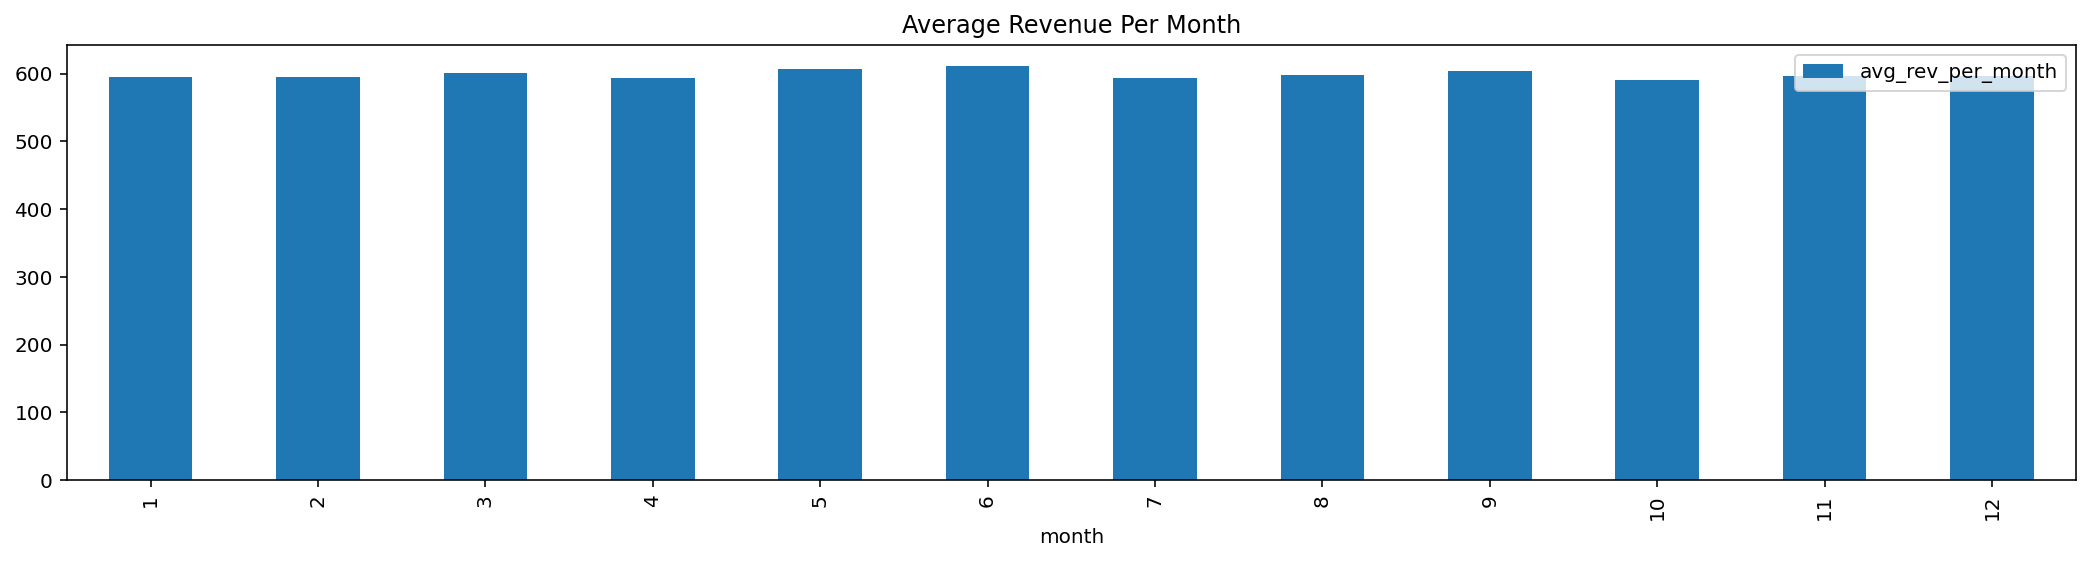

In [0]:
avg_rev_per_month.toPandas().plot.bar(x='month', title='Average Revenue Per Month');


In [0]:
#Group Revenues per Month per Year 
# multiple groupby condition

year_month_groupby = spark.sql(
        """SELECT YEAR(o.order_date) as order_year, MONTH(o.order_date) as order_month, CAST(SUM(oi.order_item_subtotal) AS DECIMAL(38,2)) as tot_revenue 
          FROM orders o JOIN order_items oi 
          ON o.order_id = oi.order_item_order_id
          GROUP BY order_year, order_month GROUPING SETS((order_year, order_month))
          ORDER BY order_year, order_month
        """).show(50)

+----------+-----------+-----------+
|order_year|order_month|tot_revenue|
+----------+-----------+-----------+
|      2013|          7|  764782.20|
|      2013|          8| 2828658.75|
|      2013|          9| 2934527.33|
|      2013|         10| 2624600.66|
|      2013|         11| 3168656.09|
|      2013|         12| 2932964.33|
|      2014|          1| 2924447.07|
|      2014|          2| 2778663.71|
|      2014|          3| 2862492.27|
|      2014|          4| 2807789.85|
|      2014|          5| 2753078.27|
|      2014|          6| 2703463.49|
|      2014|          7| 2238496.56|
+----------+-----------+-----------+



In [0]:
#total revenue irrespective of the order_year and order_month
#total revenue per order_year irrespective of the order_month
#total revenue per order_month irrespective of the order_year
#total revenue per order_year per order_month

spark.sql(
        """SELECT YEAR(o.order_date) as order_year, MONTH(o.order_date) as order_month, CAST(SUM(oi.order_item_subtotal) AS DECIMAL(38,2)) as tot_revenue  
          FROM orders o JOIN order_items oi 
          ON o.order_id = oi.order_item_order_id
          GROUP BY order_year, order_month GROUPING SETS((order_year, order_month), (order_year), (order_month), ())
          ORDER BY order_year, order_month
        """).show(50)

+----------+-----------+-----------+
|order_year|order_month|tot_revenue|
+----------+-----------+-----------+
|      null|       null|34322620.60|
|      null|          1| 2924447.07|
|      null|          2| 2778663.71|
|      null|          3| 2862492.27|
|      null|          4| 2807789.85|
|      null|          5| 2753078.27|
|      null|          6| 2703463.49|
|      null|          7| 3003278.77|
|      null|          8| 2828658.75|
|      null|          9| 2934527.33|
|      null|         10| 2624600.66|
|      null|         11| 3168656.09|
|      null|         12| 2932964.33|
|      2013|       null|15254189.37|
|      2013|          7|  764782.20|
|      2013|          8| 2828658.75|
|      2013|          9| 2934527.33|
|      2013|         10| 2624600.66|
|      2013|         11| 3168656.09|
|      2013|         12| 2932964.33|
|      2014|       null|19068431.23|
|      2014|          1| 2924447.07|
|      2014|          2| 2778663.71|
|      2014|          3| 2862492.27|
|

In [0]:
# Top Performing Departments 
spark.sql(
        """SELECT d.department_name, YEAR(o.order_date) as order_year, SUM(oi.order_item_subtotal) as tot_revenue
          FROM orders o 
              INNER JOIN order_items oi 
                  ON o.order_id = oi.order_item_order_id
              INNER JOIN products p
                  ON oi.order_item_product_id = p.product_id
              INNER JOIN categories c
                  ON c.category_id = p.product_category_id
              INNER JOIN departments d
                  ON c.category_department_id = d.department_id
          WHERE o.order_status <> 'CANCELED' AND o.order_status <> 'SUSPECTED_FRAUD'
          GROUP BY d.department_name, order_year
          ORDER BY d.department_name, order_year
        """).show(truncate=False)

+---------------+----------+------------------+
|department_name|order_year|tot_revenue       |
+---------------+----------+------------------+
|Apparel        |2013      |3090985.6535224915|
|Apparel        |2014      |3917585.841217041 |
|Fan Shop       |2013      |7290831.879999161 |
|Fan Shop       |2014      |9095735.77280426  |
|Fitness        |2013      |119526.58082199097|
|Fitness        |2014      |150509.1409931183 |
|Footwear       |2013      |1711492.5186824799|
|Footwear       |2014      |2122339.649032593 |
|Golf           |2013      |1967396.959728241 |
|Golf           |2014      |2440585.2815055847|
|Outdoors       |2013      |420317.9507675171 |
|Outdoors       |2014      |532437.6709976196 |
+---------------+----------+------------------+



In [0]:
# same work as above cell but in dataframe
# use multiple join to reach department from order 
# first order to order_item, order_item to order_item_prod_id then product then department
df = (orders_df
      .filter((orders_df.order_status != 'CANCELED') & (orders_df.order_status != 'SUSPECTED_FRAUD'))
      .join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id, how='inner')
      .join(products_df, order_items_df.order_item_product_id == products_df.product_id, how='inner')
      .join(categories_df, products_df.product_category_id == categories_df.category_id, how='inner')
      .join(departments_df, categories_df.category_department_id == departments_df.department_id, how='inner')
      .select('department_name', F.year(orders_df.order_date).alias('order_year'), 'order_item_subtotal')
      .groupBy([departments_df.department_name, 'order_year'])
      .agg(F.sum(order_items_df.order_item_subtotal).alias('tot_revenue'))
      .orderBy('department_name', 'order_year'))
df.cache()

Out[100]: DataFrame[department_name: string, order_year: int, tot_revenue: double]

In [0]:
df.show()


+---------------+----------+------------------+
|department_name|order_year|       tot_revenue|
+---------------+----------+------------------+
|        Apparel|      2013|3090985.6535224915|
|        Apparel|      2014| 3917585.841217041|
|       Fan Shop|      2013| 7290831.879999161|
|       Fan Shop|      2014|  9095735.77280426|
|        Fitness|      2013|119526.58082199097|
|        Fitness|      2014| 150509.1409931183|
|       Footwear|      2013|1711492.5186824799|
|       Footwear|      2014| 2122339.649032593|
|           Golf|      2013| 1967396.959728241|
|           Golf|      2014|2440585.2815055847|
|       Outdoors|      2013| 420317.9507675171|
|       Outdoors|      2014| 532437.6709976196|
+---------------+----------+------------------+



In [0]:

pdf = df.toPandas()
pdf = pdf.pivot(index='department_name', columns='order_year', values='tot_revenue')
print(pdf)


order_year               2013          2014
department_name                            
Apparel          3.090986e+06  3.917586e+06
Fan Shop         7.290832e+06  9.095736e+06
Fitness          1.195266e+05  1.505091e+05
Footwear         1.711493e+06  2.122340e+06
Golf             1.967397e+06  2.440585e+06
Outdoors         4.203180e+05  5.324377e+05


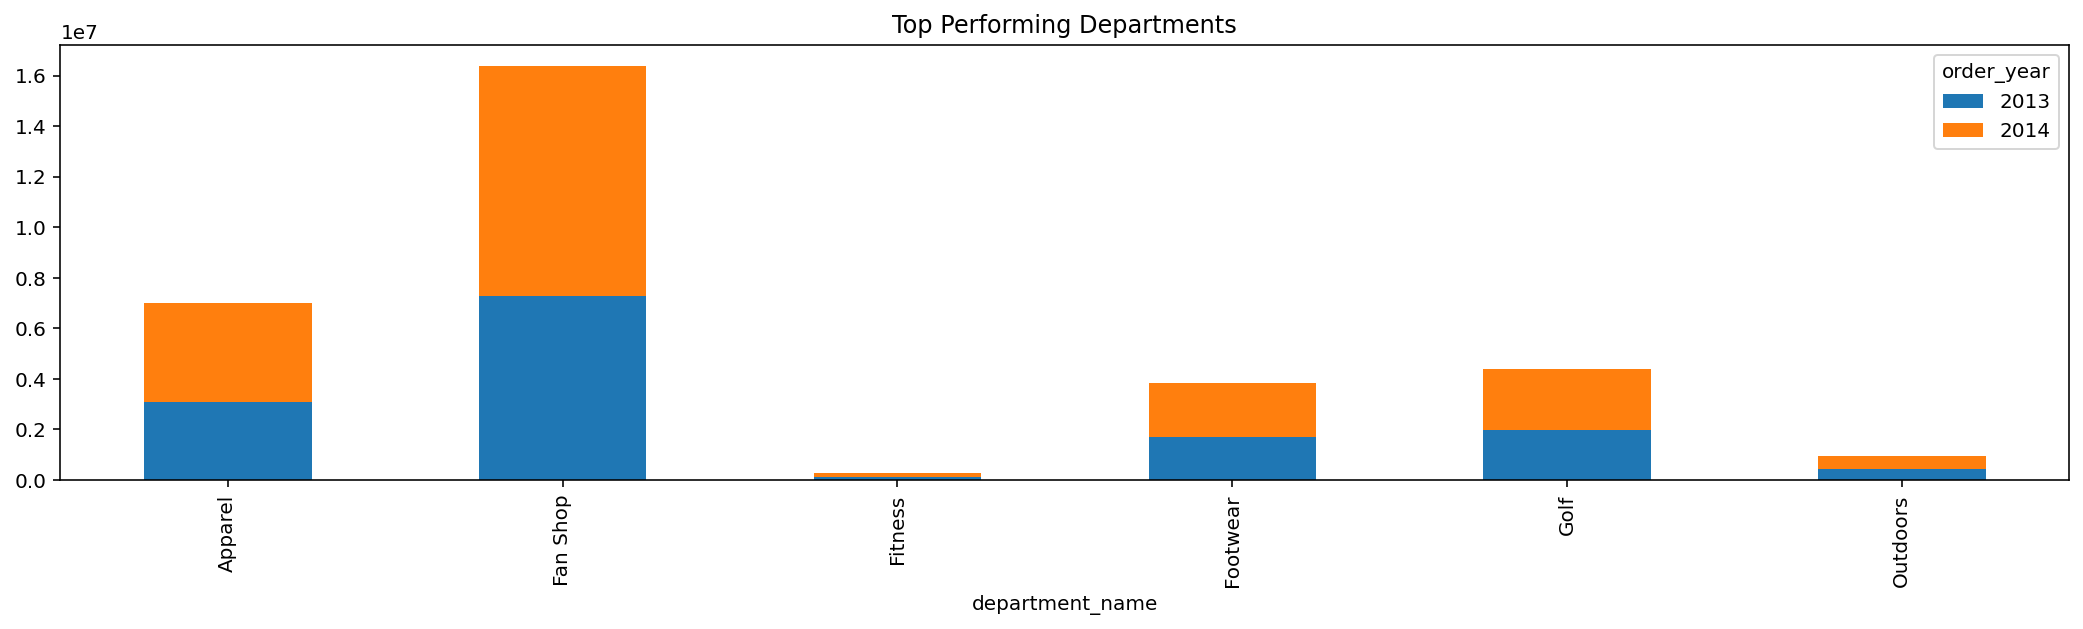

In [0]:
pdf.plot.bar(stacked=True, title='Top Performing Departments');


In [0]:
df.unpersist()

Out[104]: DataFrame[department_name: string, order_year: int, tot_revenue: double]

In [0]:
# Get Highest Priced Product
spark.sql(
        """SELECT p.* 
          FROM products p
          WHERE p.product_price = (SELECT MAX(q.product_price) FROM products q)
        """).show()

+----------+-------------------+-------------------+-------------------+-------------+--------------------+
|product_id|product_category_id|       product_name|product_description|product_price|       product_image|
+----------+-------------------+-------------------+-------------------+-------------+--------------------+
|       208|                 10|SOLE E35 Elliptical|               null|      1999.99|http://images.acm...|
+----------+-------------------+-------------------+-------------------+-------------+--------------------+



In [0]:
# SQL Using rank() Window Function:
spark.sql(
"""SELECT * FROM (SELECT *,RANK() OVER (ORDER BY product_price DESC) as rank FROM products) tmp WHERE rank <= 1""").show()

+----------+-------------------+-------------------+-------------------+-------------+--------------------+----+
|product_id|product_category_id|       product_name|product_description|product_price|       product_image|rank|
+----------+-------------------+-------------------+-------------------+-------------+--------------------+----+
|       208|                 10|SOLE E35 Elliptical|               null|      1999.99|http://images.acm...|   1|
+----------+-------------------+-------------------+-------------------+-------------+--------------------+----+



In [0]:
# Get Highest Revenue Earning Products

spark.sql("""SELECT p.*, r.product_revenue FROM products p, (SELECT oi.order_item_product_id, SUM(CAST(oi.order_item_subtotal as float)) as product_revenue FROM order_items oi GROUP BY order_item_product_id ORDER BY product_revenue DESC LIMIT 1) r
WHERE product_id = r.order_item_product_id""").show()

+----------+-------------------+--------------------+-------------------+-------------+--------------------+-----------------+
|product_id|product_category_id|        product_name|product_description|product_price|       product_image|  product_revenue|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+-----------------+
|      1004|                 45|Field & Stream Sp...|               null|       399.98|http://images.acm...|6929653.690338135|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+-----------------+



In [0]:
# User Defined Function like LAMBDA or any other FUNtion can be only when we
# REGISER in SQL Context

#Top 5 Highest Revenue Earning Products Per Month Per Year

In [0]:
# Map from month number to actual month string
monthmap = {1:"Jan", 2:"Feb", 3:"Mar",  4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}


In [0]:
# in order to use an udf with sql it needs to be registerd to sqlContext
sqlContext.udf.register("udfmonTomonth", lambda m: monthmap[m], StringType())


Out[110]: <function __main__.<lambda>(m)>

In [0]:
#Top 5 Highest Revenue Earning Products Per Month Per Year
df = spark.sql(
        """SELECT q.* 
          FROM (
               SELECT r.*, DENSE_RANK() OVER (PARTITION by order_year, order_month ORDER BY product_revenue DESC) as dense_rank
               FROM (
                    SELECT YEAR(o.order_date) as order_year, udfmonTomonth(MONTH(o.order_date)) as order_month, p.product_name, ROUND(SUM(CAST(oi.order_item_subtotal as float)), 2) as product_revenue
                    FROM order_items oi 
                        INNER JOIN orders o 
                            ON oi.order_item_order_id = o.order_id
                        INNER JOIN products p
                            ON oi.order_item_product_id = p.product_id
                        WHERE o.order_status <> 'CANCELED' AND o.order_status <> 'SUSPECTED_FRAUD'
                        GROUP BY order_year, order_month, p.product_name ) r ) q
          WHERE q.dense_rank <= 5
          ORDER BY q.order_year, q.order_month, q.dense_rank
        """)

df.cache()
df.show(10)

+----------+-----------+--------------------+---------------+----------+
|order_year|order_month|        product_name|product_revenue|dense_rank|
+----------+-----------+--------------------+---------------+----------+
|      2013|        Aug|Field & Stream Sp...|      540772.97|         1|
|      2013|        Aug|Perfect Fitness P...|      349861.69|         2|
|      2013|        Aug|Diamondback Women...|      319778.69|         3|
|      2013|        Aug|Nike Men's Free 5...|      279172.08|         4|
|      2013|        Aug|Nike Men's Dri-FI...|       247700.0|         5|
|      2013|        Dec|Field & Stream Sp...|      595570.24|         1|
|      2013|        Dec|Perfect Fitness P...|      342842.86|         2|
|      2013|        Dec|Diamondback Women...|      336277.59|         3|
|      2013|        Dec|Nike Men's Free 5...|      298370.16|         4|
|      2013|        Dec|Pelican Sunstream...|      249987.51|         5|
+----------+-----------+--------------------+------

In [0]:
#Get the most popular Categories
spark.sql(
        """SELECT c.category_name, COUNT(order_item_quantity) as order_count 
          FROM order_items oi 
          INNER JOIN products p on oi.order_item_product_id = p.product_id 
          INNER JOIN categories c on c.category_id = p.product_category_id 
          GROUP BY c.category_name 
          ORDER BY order_count DESC 
          LIMIT 10 
        """).show()

+--------------------+-----------+
|       category_name|order_count|
+--------------------+-----------+
|              Cleats|      24551|
|      Men's Footwear|      22246|
|     Women's Apparel|      21035|
|Indoor/Outdoor Games|      19298|
|             Fishing|      17325|
|        Water Sports|      15540|
|    Camping & Hiking|      13729|
|    Cardio Equipment|      12487|
|       Shop By Sport|      10984|
|         Electronics|       3156|
+--------------------+-----------+



In [0]:

# PIVOT using DATAFRAME

#Find Quarter wise ToTal

# get quater from order date coloumn

rev_cat_qt_df = (spark.sql(
            """SELECT c.category_name, YEAR(o.order_date) as order_year, CONCAT('Q', QUARTER(o.order_date)) as order_quarter, order_item_subtotal
              FROM orders o 
              INNER JOIN order_items oi on order_item_order_id = o.order_id
              INNER JOIN products p on oi.order_item_product_id = p.product_id 
              INNER JOIN categories c on p.product_category_id = c.category_id
              WHERE o.order_status <> 'CANCELED' AND o.order_status <> 'SUSPECTED_FRAUD'"""))

rev_cat_qt_df.cache()
rev_cat_qt_df.show(50)

+--------------------+----------+-------------+-------------------+
|       category_name|order_year|order_quarter|order_item_subtotal|
+--------------------+----------+-------------+-------------------+
|    Camping & Hiking|      2013|           Q3|             299.98|
|        Water Sports|      2013|           Q3|             199.99|
|     Women's Apparel|      2013|           Q3|              250.0|
|      Men's Footwear|      2013|           Q3|             129.99|
|         Accessories|      2013|           Q3|              49.98|
|              Cleats|      2013|           Q3|             299.95|
|     Women's Apparel|      2013|           Q3|              150.0|
|Indoor/Outdoor Games|      2013|           Q3|             199.92|
|    Camping & Hiking|      2013|           Q3|             299.98|
|              Cleats|      2013|           Q3|             299.95|
|Indoor/Outdoor Games|      2013|           Q3|              99.96|
|    Camping & Hiking|      2013|           Q3| 

In [0]:
rev_cat_qt_pivot_df = (rev_cat_qt_df
              .groupBy('category_name', 'order_year')
              .pivot('order_quarter', ['Q1', 'Q2', 'Q3', 'Q4']) 
# specifying the unique values (if we know) for pivot column makes execution faster
              .agg(F.round(F.sum('order_item_subtotal'), 2))
              .withColumn('total_sales', F.round(F.coalesce(col('Q1'), F.lit(0)) + F.coalesce(col('Q2'), F.lit(0)) + F.coalesce(col('Q3'), F.lit(0)) + F.coalesce(col('Q4'), F.lit(0)), 2))
              .orderBy('total_sales', ascending=False))

rev_cat_qt_pivot_df.cache()
rev_cat_qt_pivot_df.show(10)

+----------------+----------+----------+----------+----------+----------+-----------+
|   category_name|order_year|        Q1|        Q2|        Q3|        Q4|total_sales|
+----------------+----------+----------+----------+----------+----------+-----------+
|         Fishing|      2014|1673916.35| 1594720.3| 415179.25|      null|  3683815.9|
|         Fishing|      2013|      null|      null|1248337.61|1705514.77| 2953852.38|
|          Cleats|      2014|1080480.24|1027808.94| 270734.96|      null| 2379024.14|
|Camping & Hiking|      2014| 981834.58| 935637.65| 273281.79|      null| 2190754.02|
|Cardio Equipment|      2014| 855664.98| 873333.24| 223277.91|      null| 1952276.13|
|          Cleats|      2013|      null|      null| 806026.14|1059543.73| 1865569.87|
|Camping & Hiking|      2013|      null|      null| 745750.31|1010332.68| 1756082.99|
| Women's Apparel|      2014|  756700.0|  728450.0|  196000.0|      null|  1681150.0|
|    Water Sports|      2014| 740763.07| 715814.31| 20

In [0]:
#SQL (post Spark 2.4.0)
#With Spark 2.4.0 SQL equivalent pivot function was introduced. Now we can achieve the same with one query instead to DF + SQL combination.


(spark.sql(
"""SELECT *, ROUND(COALESCE(Q1, 0) + COALESCE(Q2, 0) + COALESCE(Q3, 0) + COALESCE(Q4, 0), 2) as total_sales FROM (
     SELECT * FROM (
        SELECT c.category_name, YEAR(o.order_date) as order_year, CONCAT('Q', QUARTER(o.order_date)) as order_quarter, order_item_subtotal
        FROM orders o 
        INNER JOIN order_items oi on order_item_order_id = o.order_id
        INNER JOIN products p on oi.order_item_product_id = p.product_id 
        INNER JOIN categories c on p.product_category_id = c.category_id
        WHERE o.order_status <> 'CANCELED' AND o.order_status <> 'SUSPECTED_FRAUD'
     )
     PIVOT (
        ROUND(SUM(order_item_subtotal), 2)
        FOR order_quarter in ('Q1', 'Q2', 'Q3', 'Q4')
     )
   )
   ORDER BY total_sales DESC
""")).show()

+--------------------+----------+----------+----------+----------+----------+-----------+
|       category_name|order_year|        Q1|        Q2|        Q3|        Q4|total_sales|
+--------------------+----------+----------+----------+----------+----------+-----------+
|             Fishing|      2014|1673916.35| 1594720.3| 415179.25|      null|  3683815.9|
|             Fishing|      2013|      null|      null|1248337.61|1705514.77| 2953852.38|
|              Cleats|      2014|1080480.24|1027808.94| 270734.96|      null| 2379024.14|
|    Camping & Hiking|      2014| 981834.58| 935637.65| 273281.79|      null| 2190754.02|
|    Cardio Equipment|      2014| 855664.98| 873333.24| 223277.91|      null| 1952276.13|
|              Cleats|      2013|      null|      null| 806026.14|1059543.73| 1865569.87|
|    Camping & Hiking|      2013|      null|      null| 745750.31|1010332.68| 1756082.99|
|     Women's Apparel|      2014|  756700.0|  728450.0|  196000.0|      null|  1681150.0|
|        W

In [0]:
# filter out item sales for Fishing in 2013
spark.sql(
        """SELECT c.category_name, YEAR(o.order_date) as order_year, concat('Q', QUARTER(o.order_date)) as order_quarter, ROUND(SUM(oi.order_item_subtotal), 2) as order_total 
          FROM orders o 
          INNER JOIN order_items oi on order_item_order_id = o.order_id
          INNER JOIN products p on oi.order_item_product_id = p.product_id 
          INNER JOIN categories c on p.product_category_id = c.category_id
          WHERE o.order_status <> 'CANCELED' AND o.order_status <> 'SUSPECTED_FRAUD'
          AND YEAR(o.order_date) = 2013
          AND c.category_name = 'Fishing'
          GROUP BY c.category_name, order_year, order_quarter
          ORDER BY order_year, order_quarter, order_total DESC
        """).show()

+-------------+----------+-------------+-----------+
|category_name|order_year|order_quarter|order_total|
+-------------+----------+-------------+-----------+
|      Fishing|      2013|           Q3| 1248337.61|
|      Fishing|      2013|           Q4| 1705514.77|
+-------------+----------+-------------+-----------+



In [0]:
# SUM of QUATER 3 and Quater 4 and Year 2013
rev_cat_qt_pivot_df.filter(col('order_year') == 2013).filter(col('category_name') == 'Fishing').show()


+-------------+----------+----+----+----------+----------+-----------+
|category_name|order_year|  Q1|  Q2|        Q3|        Q4|total_sales|
+-------------+----------+----+----+----------+----------+-----------+
|      Fishing|      2013|null|null|1248337.61|1705514.77| 2953852.38|
+-------------+----------+----+----+----------+----------+-----------+



In [0]:
# FOR VISUALIZING WE CONVERT SPARK df INTO PANDAS df
v_cat_qt_pivot_pdf = rev_cat_qt_pivot_df.filter(col('order_year') == 2013).cache().toPandas()

rev_cat_qt_pivot_pdf.head()


,category_name,order_year,Q1,Q2,Q3,Q4,total_sales
0,Fishing,2013,NaN,NaN,1248337.61,1705514.77,2953852.38
1,Cleats,2013,NaN,NaN,806026.14,1059543.73,1865569.87
2,Camping & Hiking,2013,NaN,NaN,745750.31,1010332.68,1756082.99
3,Cardio Equipment,2013,NaN,NaN,686091.93,894921.15,1581013.08
4,Women's Apparel,2013,NaN,NaN,564200.00,766250.00,1330450.00


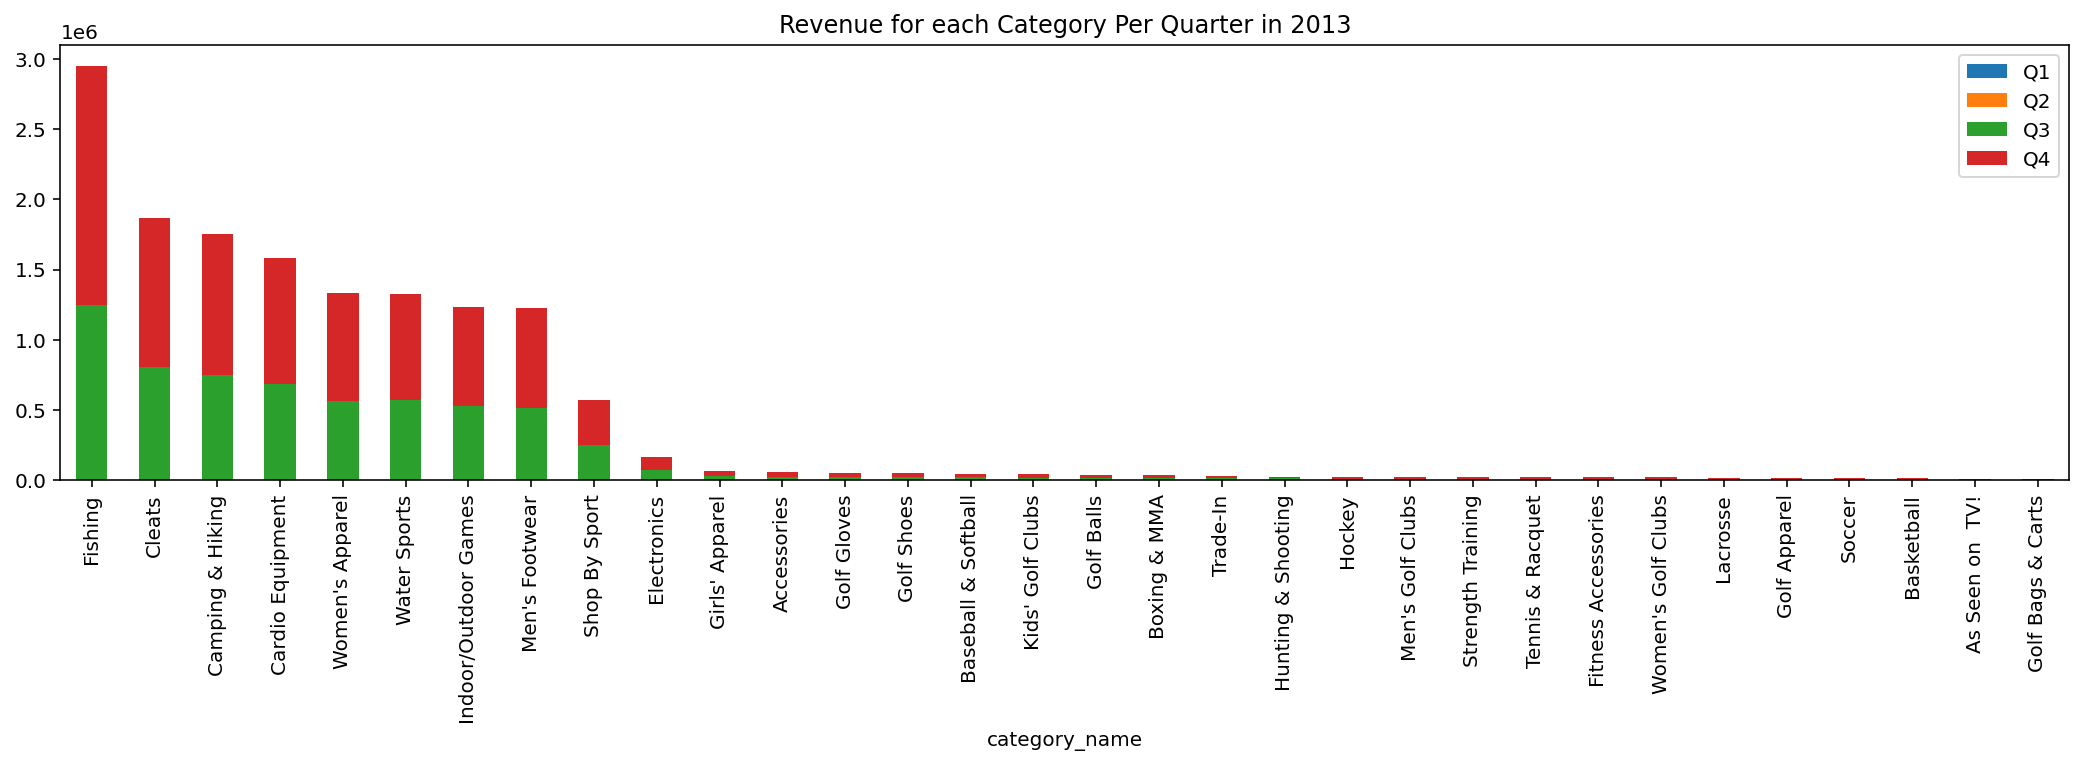

In [0]:
rev_cat_qt_pivot_pdf.drop(['order_year', 'total_sales'], axis=1).plot.bar(x='category_name', stacked=True, title='Revenue for each Category Per Quarter in 2013');


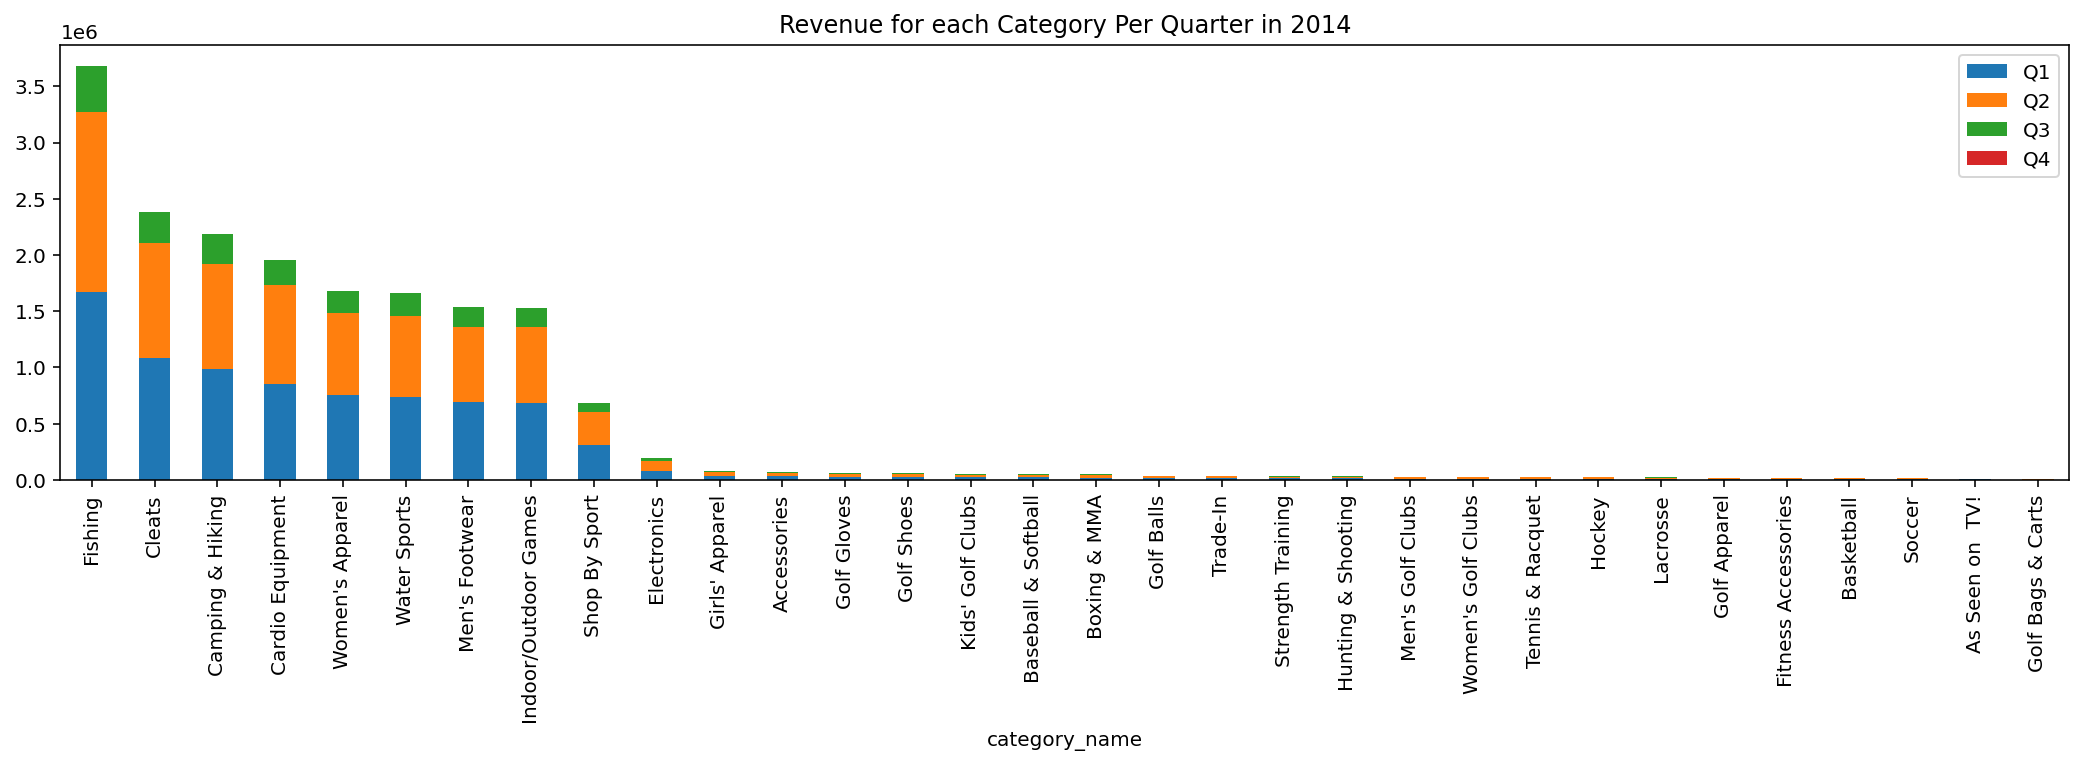

In [0]:
# year 2014
rev_cat_qt_pivot_pdf = rev_cat_qt_pivot_df.filter(col('order_year') == 2014).cache().toPandas()
rev_cat_qt_pivot_pdf.drop(['order_year', 'total_sales'], axis=1).plot.bar(x='category_name', stacked=True, title='Revenue for each Category Per Quarter in 2014');


In [0]:
#Get Number of Orders By Status

spark.sql(
        """SELECT order_status, COUNT(1) as total
          FROM orders o
          GROUP BY o.order_status
        """).show()

+---------------+-----+
|   order_status|total|
+---------------+-----+
|PENDING_PAYMENT|15030|
|       COMPLETE|22899|
|        ON_HOLD| 3798|
| PAYMENT_REVIEW|  729|
|     PROCESSING| 8275|
|         CLOSED| 7556|
|SUSPECTED_FRAUD| 1558|
|        PENDING| 7610|
|       CANCELED| 1428|
+---------------+-----+



In [0]:
# samne as above we perform same operation with dataframe

df=orders_df.groupBy(orders_df.order_status).count().withColumnRenamed('count', 'total')
df.cache()

df.show()

+---------------+-----+
|   order_status|total|
+---------------+-----+
|PENDING_PAYMENT|15030|
|       COMPLETE|22899|
|        ON_HOLD| 3798|
| PAYMENT_REVIEW|  729|
|     PROCESSING| 8275|
|         CLOSED| 7556|
|SUSPECTED_FRAUD| 1558|
|        PENDING| 7610|
|       CANCELED| 1428|
+---------------+-----+



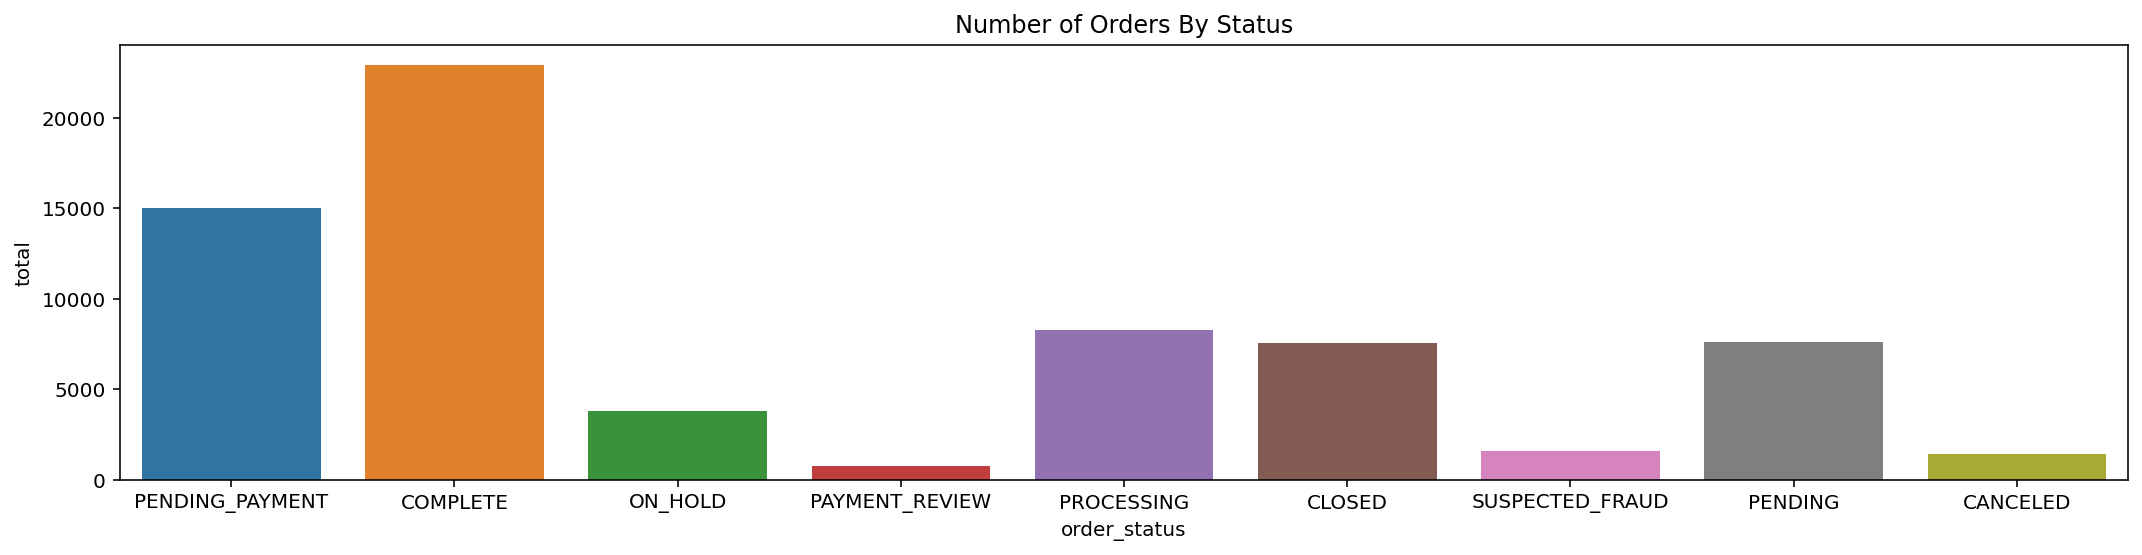

In [0]:
pdf = df.toPandas()
g = sns.barplot(x='order_status', y='total', data=pdf)
g.set_title('Number of Orders By Status');

In [0]:
 # Get Number of Orders By Order Date and Order Status
spark.sql(
        """SELECT order_date, order_status, COUNT(1) as total FROM orders o GROUP BY order_date, o.order_status""").show(truncate=False)

+---------------------+---------------+-----+
|order_date           |order_status   |total|
+---------------------+---------------+-----+
|2013-08-16 00:00:00.0|COMPLETE       |43   |
|2013-08-30 00:00:00.0|CLOSED         |17   |
|2013-09-10 00:00:00.0|COMPLETE       |80   |
|2013-10-05 00:00:00.0|SUSPECTED_FRAUD|4    |
|2013-12-02 00:00:00.0|SUSPECTED_FRAUD|3    |
|2013-12-09 00:00:00.0|ON_HOLD        |9    |
|2013-12-20 00:00:00.0|SUSPECTED_FRAUD|3    |
|2013-12-23 00:00:00.0|PAYMENT_REVIEW |2    |
|2014-01-02 00:00:00.0|CLOSED         |15   |
|2014-02-11 00:00:00.0|CANCELED       |3    |
|2014-02-14 00:00:00.0|ON_HOLD        |11   |
|2014-02-21 00:00:00.0|PROCESSING     |25   |
|2014-05-13 00:00:00.0|SUSPECTED_FRAUD|3    |
|2014-06-27 00:00:00.0|PENDING        |26   |
|2014-07-16 00:00:00.0|ON_HOLD        |3    |
|2013-08-16 00:00:00.0|PENDING_PAYMENT|30   |
|2013-08-29 00:00:00.0|PROCESSING     |31   |
|2013-09-10 00:00:00.0|SUSPECTED_FRAUD|3    |
|2013-09-25 00:00:00.0|CLOSED     

In [0]:
#Get all CANCELED orders with amount greater than $1000

spark.sql(
       """SELECT q.* 
      FROM (SELECT o.order_id, o.order_date, o.order_customer_id, o.order_status, SUM(oi.order_item_subtotal) as order_total 
            FROM orders o INNER JOIN order_items oi 
                ON o.order_id = oi.order_item_order_id 
            WHERE o.order_status = 'CANCELED' 
            GROUP BY o.order_id, o.order_date, o.order_customer_id, o.order_status) q 
     WHERE q.order_total >= 1000 
     ORDER BY q.order_id""").show(truncate=False)

+--------+---------------------+-----------------+------------+------------------+
|order_id|order_date           |order_customer_id|order_status|order_total       |
+--------+---------------------+-----------------+------------+------------------+
|753     |2013-07-29 00:00:00.0|5094             |CANCELED    |1129.75           |
|2012    |2013-08-04 00:00:00.0|5165             |CANCELED    |1499.8600311279297|
|2144    |2013-08-05 00:00:00.0|7932             |CANCELED    |1099.900032043457 |
|2189    |2013-08-06 00:00:00.0|6829             |CANCELED    |1029.9400253295898|
|2271    |2013-08-06 00:00:00.0|7603             |CANCELED    |1229.9300231933594|
|2754    |2013-08-09 00:00:00.0|8946             |CANCELED    |1109.9500274658203|
|3551    |2013-08-14 00:00:00.0|5363             |CANCELED    |1299.8700408935547|
|4354    |2013-08-20 00:00:00.0|7268             |CANCELED    |1047.9000244140625|
|4801    |2013-08-23 00:00:00.0|11630            |CANCELED    |1016.9500217437744|
|533

In [0]:
# Same Working using pandas dataframe 
cancelled_orders = (orders_df
                 .filter(col('order_status') == 'CANCELED')
                 .join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id)
                 .groupBy(orders_df.order_id, orders_df.order_date, orders_df.order_customer_id, orders_df.order_status)
                 .agg(F.sum('order_item_subtotal').alias('order_total'))
                 .filter(col('order_total') >= 1000)
                 .orderBy('order_id'))

cancelled_orders.cache()

cancelled_orders.show(truncate=False)


+--------+---------------------+-----------------+------------+------------------+
|order_id|order_date           |order_customer_id|order_status|order_total       |
+--------+---------------------+-----------------+------------+------------------+
|753     |2013-07-29 00:00:00.0|5094             |CANCELED    |1129.75           |
|2012    |2013-08-04 00:00:00.0|5165             |CANCELED    |1499.8600311279297|
|2144    |2013-08-05 00:00:00.0|7932             |CANCELED    |1099.900032043457 |
|2189    |2013-08-06 00:00:00.0|6829             |CANCELED    |1029.9400253295898|
|2271    |2013-08-06 00:00:00.0|7603             |CANCELED    |1229.9300231933594|
|2754    |2013-08-09 00:00:00.0|8946             |CANCELED    |1109.9500274658203|
|3551    |2013-08-14 00:00:00.0|5363             |CANCELED    |1299.8700408935547|
|4354    |2013-08-20 00:00:00.0|7268             |CANCELED    |1047.9000244140625|
|4801    |2013-08-23 00:00:00.0|11630            |CANCELED    |1016.9500217437744|
|533

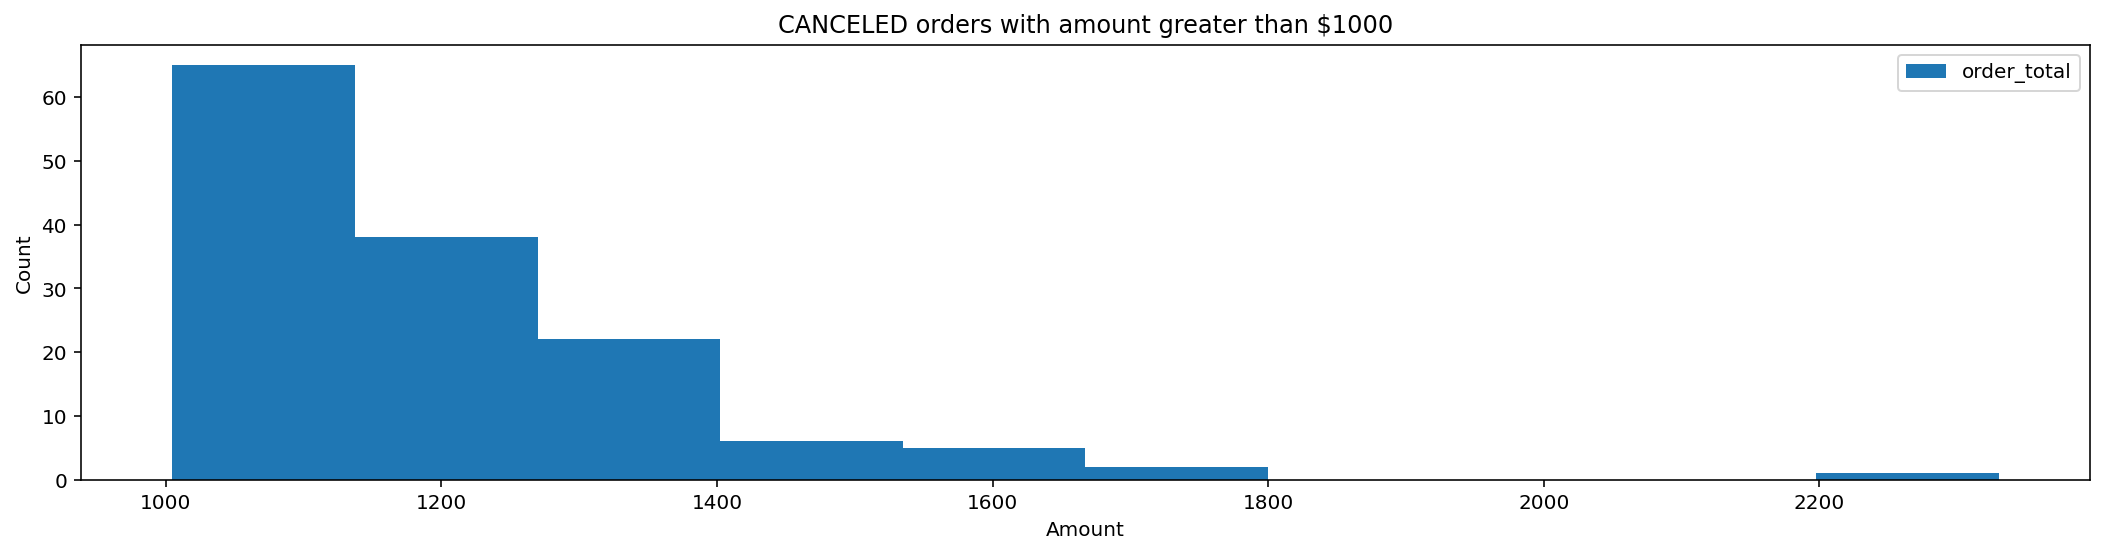

In [0]:
# for visualize we again follow the same step
# convert spark datframe in to pandas dataframe

ax = cancelled_orders.toPandas().plot.hist(y='order_total', title='CANCELED orders with amount greater than $1000')
ax.set(xlabel='Amount', ylabel='Count');

In [0]:
spark.sql(
 """SELECT p.product_id,c.category_name, p.product_name, p.product_price FROM products p INNER JOIN categories c ON p.product_category_id =c.category_id ORDER BY c.category_name ASC, p.product_price DESC""").show(truncate=False)

+----------+-------------+---------------------------------------------+-------------+
|product_id|category_name|product_name                                 |product_price|
+----------+-------------+---------------------------------------------+-------------+
|496       |Accessories  |SOLE F85 Treadmill                           |1799.99      |
|488       |Accessories  |SOLE E25 Elliptical                          |999.99       |
|481       |Accessories  |Top Flite Women's XL 12-Piece Complete Set - |179.98       |
|487       |Accessories  |Jordan Men's VI Retro TD Football Cleat      |134.99       |
|484       |Accessories  |Nike Men's Free 5.0+ Running Shoe            |99.99        |
|489       |Accessories  |Nike Kids' Grade School KD VI Basketball Shoe|99.99        |
|492       |Accessories  |Nike Men's Free 5.0 Running Shoe             |99.99        |
|497       |Accessories  |Nike Women's Free 5.0+ Running Shoe          |99.99        |
|482       |Accessories  |Fitbit Flex Wirel

In [0]:
#Get the topmost 5 products overall sorted by Price Highest to Lowest
# Also done with DENSE RANK function but it shows more records
spark.sql(
        """SELECT product_id, product_category_id, product_name, product_price
          FROM products
          ORDER BY product_price DESC
          LIMIT 5
        """).show(truncate=False)

+----------+-------------------+------------------------------------------------+-------------+
|product_id|product_category_id|product_name                                    |product_price|
+----------+-------------------+------------------------------------------------+-------------+
|208       |10                 |SOLE E35 Elliptical                             |1999.99      |
|66        |4                  |SOLE F85 Treadmill                              |1799.99      |
|199       |10                 |SOLE F85 Treadmill                              |1799.99      |
|496       |22                 |SOLE F85 Treadmill                              |1799.99      |
|1048      |47                 |"Spalding Beast 60"" Glass Portable Basketball "|1099.99      |
+----------+-------------------+------------------------------------------------+-------------+



In [0]:
#Get the topmost 5 products in each category where the products are sorted by Price Highest to Lowest

spark.sql(
        """SELECT product_category_id, product_id, product_name, product_price, row_num
          FROM ( 
               SELECT q.*, row_number() OVER (PARTITION BY q.product_category_id ORDER BY q.product_price DESC) as row_num 
               FROM products q)
          WHERE row_num <= 5 
          ORDER BY product_category_id, row_num
                
        """).show(truncate=False)

+-------------------+----------+------------------------------------------------+-------------+-------+
|product_category_id|product_id|product_name                                    |product_price|row_num|
+-------------------+----------+------------------------------------------------+-------------+-------+
|2                  |16        |Riddell Youth 360 Custom Football Helmet        |299.99       |1      |
|2                  |11        |Fitness Gear 300 lb Olympic Weight Set          |209.99       |2      |
|2                  |5         |Riddell Youth Revolution Speed Custom Footbal   |199.99       |3      |
|2                  |14        |Quik Shade Summit SX170 10 FT. x 10 FT. Canop   |199.99       |4      |
|2                  |12        |Under Armour Men's Highlight MC Alter Ego Fla   |139.99       |5      |
|3                  |40        |Quik Shade Summit SX170 10 FT. x 10 FT. Canop   |199.99       |1      |
|3                  |32        |PUMA Men's evoPOWER 1 Tricks FG 

In [0]:
spark.sql(
        """SELECT product_category_id, product_id, product_name, product_price, rank
          FROM ( 
               SELECT q.*, RANK() OVER (PARTITION BY q.product_category_id ORDER BY q.product_price DESC) as rank 
               FROM products q)
          WHERE rank <= 5 
          ORDER BY product_category_id, rank
                
        """).show(truncate=False)

+-------------------+----------+------------------------------------------------+-------------+----+
|product_category_id|product_id|product_name                                    |product_price|rank|
+-------------------+----------+------------------------------------------------+-------------+----+
|2                  |16        |Riddell Youth 360 Custom Football Helmet        |299.99       |1   |
|2                  |11        |Fitness Gear 300 lb Olympic Weight Set          |209.99       |2   |
|2                  |5         |Riddell Youth Revolution Speed Custom Footbal   |199.99       |3   |
|2                  |14        |Quik Shade Summit SX170 10 FT. x 10 FT. Canop   |199.99       |3   |
|2                  |12        |Under Armour Men's Highlight MC Alter Ego Fla   |139.99       |5   |
|2                  |23        |Under Armour Men's Highlight MC Alter Ego Hul   |139.99       |5   |
|3                  |40        |Quik Shade Summit SX170 10 FT. x 10 FT. Canop   |199.99    

In [0]:
spark.sql(
        """SELECT product_category_id, product_id, product_name, product_price, dense_rank
         FROM ( 
         SELECT q.*, dense_rank() OVER (PARTITION BY q.product_category_id ORDER BY q.product_price DESC) as dense_rank 
         FROM products q)
         WHERE dense_rank <= 5 
         ORDER BY product_category_id, dense_rank
               
        """).show(truncate=False)

+-------------------+----------+------------------------------------------------+-------------+----------+
|product_category_id|product_id|product_name                                    |product_price|dense_rank|
+-------------------+----------+------------------------------------------------+-------------+----------+
|2                  |16        |Riddell Youth 360 Custom Football Helmet        |299.99       |1         |
|2                  |11        |Fitness Gear 300 lb Olympic Weight Set          |209.99       |2         |
|2                  |5         |Riddell Youth Revolution Speed Custom Footbal   |199.99       |3         |
|2                  |14        |Quik Shade Summit SX170 10 FT. x 10 FT. Canop   |199.99       |3         |
|2                  |12        |Under Armour Men's Highlight MC Alter Ego Fla   |139.99       |4         |
|2                  |23        |Under Armour Men's Highlight MC Alter Ego Hul   |139.99       |4         |
|2                  |6         |Jorda